# 3. Поиск координат углов прямоугольника на изображении
Реализовать нейронную сеть, которая осуществляет поиск координат углов прямоугольников на изображении. В качестве обучающих и тестовых данных использовать ваш класс из п.1. Выходом обученной нейронной сети являются координаты 4 углов прямоугольника на изображении. Привести график функции потерь (loss function) в ходе обучения. Привести максимальное, минимальное и среднее значение L2 метрики (евклидово расстояние) для тестовой выборки из 1000 примеров для 2 разных checkpoint-ов обучения (промежуточного и финального).

## Импорт библиотек

In [ ]:
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import torch
from torchvision import transforms

from scipy.spatial import distance

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Генерация данных
Прямоугольники случайного цвета со сторонами от 150 до 250 пикселей, повернутые на случайный угол от 0 до 90 градусов.  

Фон - изображение 640 на 480 пикселей случайного цвета.

In [ ]:
class object1:
    def ran1(self):
        self.img = np.zeros((480, 640, 3), np.uint8)
        self.img[:] = (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255))
        width = random.randrange(100, 250)
        height = random.randrange(100, 250)
        diam = np.sqrt(width ** 2 + height ** 2)

        x1 = random.randrange(int(diam / 2 - width / 2), int(self.img.shape[1] - (diam / 2 - width / 2) - width))
        x2 = x1 + width
        y1 = random.randrange(int((diam / 2 - height / 2)), int(self.img.shape[0] - (diam / 2 - height / 2) - height))
        y2 = y1 + height

        points = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])

        ANGLE = np.deg2rad(random.randrange(0, 89))
        c_x, c_y = np.mean(points, axis=0)
        points = np.array([[c_x + np.cos(ANGLE) * (px - c_x) - np.sin(ANGLE) * (py - c_y),
                            c_y + np.sin(ANGLE) * (px - c_x) + np.cos(ANGLE) * (py - c_y)]
                           for px, py in points]).astype(int)

        self.points = points
        self.describe = np.array([points[3][0], points[0][1], points[1][0] - points[3][0], points[2][1] - points[0][1]])
        self.img = cv2.drawContours(self.img, [points], 0,
                               (random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)), -1)

Количество изображений для генерации

In [ ]:
num_imgs = 10000

Генерация изображений для датасета.  

Для экономии памяти преобразуем изображения в черно-белый цвет размером 28х28 пикселей.

In [ ]:
imgs = []
points = []
for i in range(num_imgs):
  image = object1()
  image.ran1()
  img = cv2.resize(image.img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgs.append(img)
  points.append(image.points)
imgs = np.array(imgs)
points = np.array(points)

Отобразим полученное изображение и координаты углов

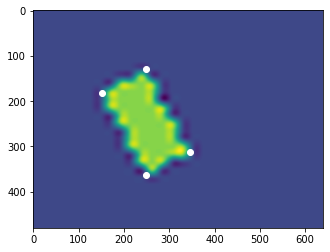

In [ ]:
i = 0
# Создадим оси и фигуру
fig, ax = plt.subplots()
# Покажем координаты точек прямоугольника
data = points[i]
x, y = data.T
plt.scatter(x,y, color='w')
# Отобразим координаты на изображении с прямоугольником
ax.imshow(cv2.resize(imgs[i], dsize=(640, 480), interpolation=cv2.INTER_CUBIC))
plt.show()

Добавим измерение глубины для изображения для правильной индексации сверточной сетью.

In [ ]:
X = torch.from_numpy(imgs).unsqueeze(1)

Сделаем нормализацию тестовых данных для экономии памяти

In [ ]:
y = points.reshape(num_imgs, -1) / 640
y = torch.from_numpy(y)

In [ ]:
X.shape, y.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000, 8]))

## Создание выборок, нейронной сети

Разобьем данные на тренировочную и тестовую выборки

In [ ]:
i = int(0.9 * num_imgs)
X_train = X[:i].float()
X_test = X[i:].float()
y_train = y[:i].float()
y_test = y[i:].float()

Запрограммируем нейронную сеть для получения предсказаний.  
Возьмем за основу сеть LeNet с пятью слоями: двумя сверточными и тремя полносвязными. На последнем слое сеть имеет 8 выходов по числу координат для предсказания.

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 8)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

Функция для расчета метрики L2 (Евклидово расстояние) для предсказанных координат.

In [ ]:
def euclid(y_batch, preds):
  e = []
  y_batch = y_batch.cpu().detach().numpy() * 640
  preds = preds.cpu().detach().numpy() * 640
  for i in range(len(preds)):
    a = preds[i]
    b = y_batch[i]
    e.append(int(distance.euclidean(a, b)))
  return max(e), min(e), np.mean(e)

Задание функции потерь и оптимизатора

In [ ]:
loss = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Тренировка нейронной сети, получение предсказаний

Обучим нейронную сеть на 400 эпохах с размером батча 100.  
Для двух точек обучения отобразим максимальное, минимальное и среднее значения метрики L2.  
Евклидово расстояние - расстояние между двумя точками евклидова пространства, вычисляемое по теореме Пифагора).

In [ ]:
check1 = 200 #первая контрольная точка
check2 = 399 #вторая контрольная точка (финальная)
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(400):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        
        loss_value.backward()
        
        optimizer.step()
    
    #print(f'эпоха {epoch}, значение потерь {loss_value}')

    if epoch == check1 or epoch == check2:
          print(f'epoch = {epoch} \n L2 max, L2 min, L2 mean: {euclid(y_batch, preds)}')

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

epoch = 200 
 L2 max, L2 min, L2 mean: (176, 3, 40.48)
epoch = 399 
 L2 max, L2 min, L2 mean: (416, 17, 85.29)


## График функции потерь

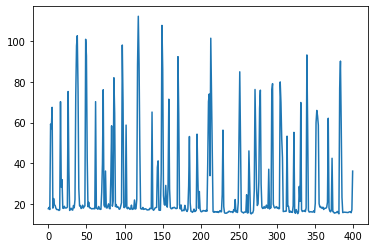

In [ ]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);

Визуализация полученных результатов.  
Красными точками отмечены координаты прямоугольника, предсказанные нейронной сетью.

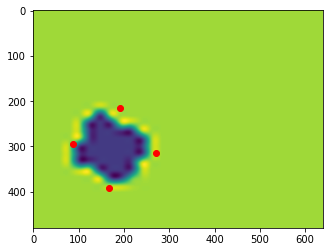

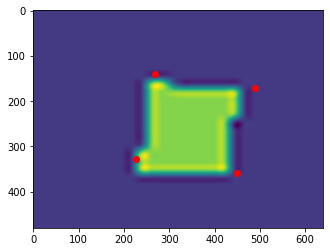

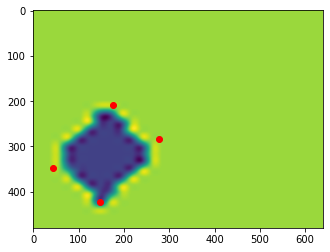

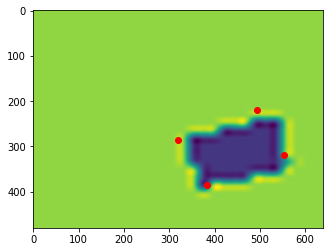

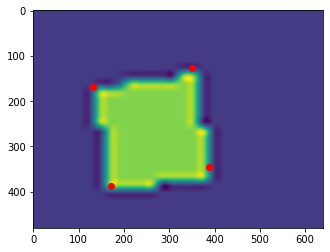

In [ ]:
for i in range(0, 100, 20):
  # Создание осей
  fig, ax = plt.subplots()
  # Показ предсказанных координат
  data = np.reshape(test_preds[i].cpu().detach().numpy(), (-1, 2)) * 640
  x, y = data.T
  plt.scatter(x,y, color='r')
  # Показ координат на картинке с прямоугольником
  ax.imshow(cv2.resize(np.squeeze(X_test[i].cpu().detach().numpy(), axis=0), dsize=(640, 480), interpolation=cv2.INTER_CUBIC))
  plt.show()